In [1]:
# from os import stat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import toml
import matplotlib.animation as anim
from IPython.display import HTML

def load_sim_states(fname):
    """Load states during simulation."""
    with open(fname, "r") as f:
        states = []
        for line in f:
            states.append(json.loads(line))
        return states
        
def load_toml(fname = "../zebra.toml"):
    """Load config toml."""
    with open(fname, "r") as f:
        parsed_toml = toml.loads(f.read())
    return parsed_toml

# Load zebra toml
# zebra_file = "../zebra_3crossings.toml"
# zebra_toml = load_toml(zebra_file)

# Load states
# states_file = "../sim_states_3crossings.json"
# states = load_sim_states(states_file)


# Testing
# state = states[100]
# ped_xs = [zebra_toml["zebra_crossings"][int(ped["location"])] for ped in state["pedestrians"]]
# veh_xs = [float(vehicle["position"]) for vehicle in state["vehicles"]]

In [2]:
# Function to create animation
def get_animation(states):
    fig = plt.figure(figsize=(10, 4))  
    ax1 = fig.add_subplot(1,1,1)
    FRAME_LIMIT = 2000
    GAP = 0.1
    WIDTH = 0.4
    LENGTH = 10
    N_STRIPES = 7
    ROAD_WIDTH = 0.15
    MAX_LENGTH = zebra_toml["road_length"] + 1

    ax1.set_xlim(0, MAX_LENGTH)
    min_y, max_y = -1, 1
    ax1.set_ylim(min_y, max_y)
    # ax1.axis("off")
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    ax1.spines.left.set_visible(False)
    ax1.tick_params(left=False)
    ax1.tick_params(labelleft=False)
    
    ped_scat, = ax1.plot([], [], color="dodgerblue", marker="o", markersize=9, ls="None")
    veh_scat_up, = ax1.plot([], [], marker=">", color="firebrick", ms=5, ls="None")
    veh_scat_down, = ax1.plot([], [], marker="<", color="purple", ms=5, ls="None")

    time_text = ax1.text(0, 1, "", ha="left", va="bottom", transform = ax1.transAxes, fontsize="large")
    
    def convert_millis(ms):
        secs = int((ms / 1000)) % 60
        mins = int(ms / (1000 * 60)) % 60
        hrs = int(ms / (1000 * 60 * 60)) % 24
        return hrs, mins, secs
    
    def init():
        vlines = ax1.vlines(np.arange(0, MAX_LENGTH, 100), min_y, max_y, ls=":", color="grey", lw=.5, zorder=-1)
        hlines = []
        for crossing in zebra_toml["zebra_crossings"]:
            hlines.append(
                ax1.hlines(np.linspace(-WIDTH, WIDTH, N_STRIPES), crossing-LENGTH/2, crossing+LENGTH/2, color="k", lw=5, zorder=-4)
            )

        ped_scat, = ax1.plot([], [], color="dodgerblue", marker="o", markersize=9, ls="None")
        veh_scat_up, = ax1.plot([], [], marker=">", color="firebrick", ms=5, ls="None")
        veh_scat_down, = ax1.plot([], [], marker="<", color="purple", ms=5, ls="None")
        time_text = ax1.text(0, 1, "", ha="left", va="bottom", transform = ax1.transAxes, fontsize="large")
        return ped_scat, veh_scat_up, veh_scat_down, time_text
    
    def animate(i):
        from matplotlib.artist import Artist
        state = states[i]
        timestamp = int(state["timestamp"])
        hrs, mins, secs = convert_millis(timestamp)
        ped_xs = [zebra_toml["zebra_crossings"][int(ped["location"])] for ped in state["pedestrians"]]
        ped_ys = []
        counts = {}
        for el in ped_xs:
            if el in counts:
                counts[el] += GAP
            else:
                counts[el] = GAP + WIDTH
            ped_ys.append(counts[el])

        veh_xs_up = [float(vehicle["position"]) for vehicle in state["vehicles"] if vehicle["direction"] == "Up"]
        veh_ys_up = len(veh_xs_up)*[ROAD_WIDTH/2]
        veh_xs_down = [zebra_toml["road_length"]-float(vehicle["position"]) for vehicle in state["vehicles"] if vehicle["direction"] == "Down"]
        veh_ys_down = len(veh_xs_down)*[-ROAD_WIDTH/2]
        
        # Update plots
        ped_scat.set_data(ped_xs, ped_ys)
        veh_scat_up.set_data(veh_xs_up, veh_ys_up)
        veh_scat_down.set_data(veh_xs_down, veh_ys_down)
        time_text.set_text(f"Time: {hrs:02.0f}h{mins:02.0f}m{secs:02.0f}s")        
        return (ped_scat, veh_scat_up, veh_scat_down, time_text)

    return anim.FuncAnimation(
        fig, animate,
        init_func=init,
        frames=np.arange(0, min(FRAME_LIMIT, len(states))),
        repeat=False,
        blit=True,
        interval=100
    )

In [3]:
# File names for two crossings
config_file = "../zebra_config_simple_2crossings.toml"
outfile = "../sim_states_simple_2crossings.json"
animation_file = "../zebra_animation_2crossings.mp4"

In [4]:
%%writefile ../zebra_config_simple_2crossings.toml
road_length = 600
zebra_crossings = [180, 440]
# zebra_crossings = [180, 300, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting ../zebra_config_simple_2crossings.toml


In [5]:
%%capture
# Run the simulation
!cargo run -- --config_file ../zebra_config_simple_2crossings.toml --outfile ../sim_states_simple_2crossings.json

In [6]:
# Load zebra toml
zebra_file = config_file
zebra_toml = load_toml(zebra_file)

# Load states
states_file = outfile
states = load_sim_states(states_file)

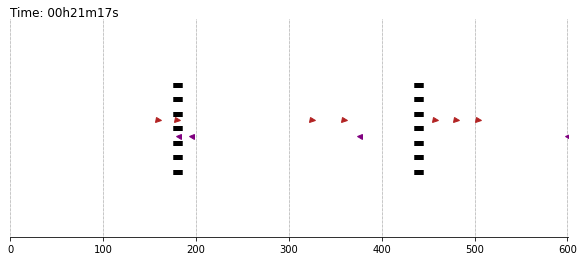

In [7]:
# Make animation and save as gif
animation = get_animation(states)
html5 = animation.to_html5_video()
HTML(html5)

In [8]:
# Save as mp4 and gif
fname = animation_file
animation.save(fname, dpi=100, fps=15, writer="ffmpeg")
# !convert zebra_animation.mp4 zebra_animation.gif
!convert zebra_animation_2crossings.mp4 zebra_animation_2crossings.gif

convert: unable to open image 'zebra_animation_2crossings.mp4': No such file or directory @ error/blob.c/OpenBlob/3568.
convert: no images defined `zebra_animation_2crossings.gif' @ error/convert.c/ConvertImageCommand/3325.


In [9]:
# File names for two crossings
config_file = "../zebra_config_simple_3crossings.toml"
outfile = "../sim_states_simple_3crossings.json"
animation_file = "../zebra_animation_3crossings.mp4"

In [10]:
%%writefile ../zebra_config_simple_3crossings.toml
road_length = 600
# zebra_crossings = [180, 440]
zebra_crossings = [180, 300, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting ../zebra_config_simple_3crossings.toml


In [11]:
%%capture
# Run the simulation
!cargo run -- --config_file ../zebra_config_simple_3crossings.toml --outfile ../sim_states_simple_3crossings.json

In [12]:
# Load zebra toml
zebra_file = config_file
zebra_toml = load_toml(zebra_file)

# Load states
states_file = outfile
states = load_sim_states(states_file)

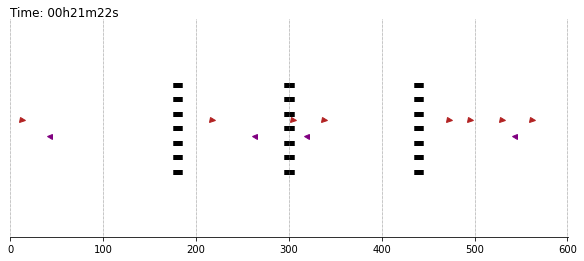

In [13]:
# Make animation and save as gif
animation = get_animation(states)
html5 = animation.to_html5_video()
HTML(html5)

In [14]:
# Save as mp4 and gif
fname = animation_file
animation.save(fname, dpi=100, fps=15, writer="ffmpeg")
# !convert zebra_animation.mp4 zebra_animation.gif
!convert zebra_animation_3crossings.mp4 zebra_animation_3crossings.gif

In [5]:
# TODO: move analysis to seperate notebook
# Load zebra toml
zebra_file = "../zebra_3crossings.toml"
zebra_toml3 = load_toml(zebra_file)

# Load states
states_file = "../sim_states_3crossings.json"
states3 = load_sim_states(states_file)


# Load zebra toml
zebra_file = "../zebra_2crossings.toml"
zebra_toml = load_toml(zebra_file)

# Load states
states_file = "../sim_states_2crossings.json"
states2 = load_sim_states(states_file)

In [6]:
def get_vehicle_arrival_and_exits(states):
    """
    Gets arrival, exit and transit times for each vehicle as a pandas df.
    """
    vehicles = set()
    vehicle_arrivals = {}
    vehicle_exits = {}
    # Loop over states
    for state in states:
        # Current time
        timestamp = state["timestamp"]
        # Current vehicles
        current_veh = set()
        # Loop over vehicles
        for vehicle in state["vehicles"]:
            vid = vehicle["id"]
            # Add vehicle ID to current set
            current_veh.add(vid)
            # If not already arrived, add time
            if vid not in vehicle_arrivals:
                vehicle_arrivals[vid] = timestamp
        # Loop over vehicles already arrived
        for vid in vehicle_arrivals:
            # If not in current vehicles and not previously exited
            if vid not in current_veh and vid not in vehicle_exits:
                # Record exit time
                vehicle_exits[vid] = timestamp
    
    # Make df from dict
    df = pd.DataFrame.from_dict(
        [vehicle_arrivals]
    ).T.rename(columns={0: "arrival"}).join(
        pd.DataFrame.from_dict(
            [vehicle_exits]
        ).T.rename(columns={0:"exit"})
    )
    # Get transit time in ms
    df["transit"] = df["exit"]-df["arrival"]

    return df

In [7]:
# Get dataframes for two and three crossing versions
df2 = get_vehicle_arrival_and_exits(states2)
df3 = get_vehicle_arrival_and_exits(states3)

57.11607911392405 57.0016835443038
54.863 54.238


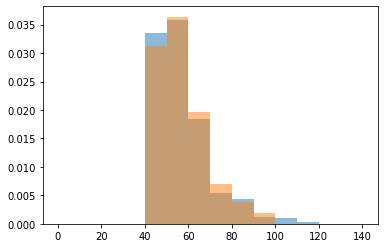

In [8]:
# Plot hists, compare means and medians
bins = np.arange(0, 150, 10)
alpha = 0.5
plt.hist(df3["transit"]/1000, density=True, bins=bins, alpha=alpha)
plt.hist(df2["transit"]/1000, density=True, bins=bins, alpha=alpha)
print(df2["transit"].mean()/1000, df3["transit"].mean()/1000)
print(df2["transit"].median()/1000, df3["transit"].median()/1000)